In [82]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import time 
import svhnl
import numpy as np
import matplotlib.pyplot as plt

Setting the gpu for m1 macbook

In [67]:
device=torch.device('mps')
device

device(type='mps')

In [68]:
transformation=torchvision.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [69]:
dataset = torchvision.datasets.ImageFolder(root='cnn_dataset', transform=transformation)

In [70]:
train_size = int(0.8 * len(dataset))
testing_size = len(dataset) - train_size
train_dataset, testing_dataset = random_split(dataset, [train_size, testing_size])

In [71]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
testing_loader=torch.utils.data.DataLoader(testing_dataset,batch_size=64,shuffle=False,num_workers=4)

In [33]:
len(dataset)

30000

We are not Resizing the image to a different pixel size.

In [75]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096,3))
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x=self.features(x)
        x=self.softmax(x)
        return x

In [76]:
model=AlexNet().to(device)

In [77]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=6400, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, out

In [78]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
def train_one_epoch(epoch_index):
    training_correct_ones=0
    running_loss=0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        #inputs= inputs.to(torch.float64)
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        maxi,predictions=torch.max(outputs,1)
        training_correct_ones+=(predictions==labels.to(device)).sum().item()
        if i % 100 == 99:    
            print(f'current epoch:{epoch_index},running_loss is {running_loss}')
            running_loss = 0.0
    return training_correct_ones             

In [47]:
epochs=10
training_epochs_1=[]
testing_epochs_1=[]
for epoch in range(epochs):
    correct_ones=0
    model.train(True)
    training_correct_ones=train_one_epoch(epoch)
    model.train(False)
    #testing error is
    for j,test_data in enumerate(testing_loader):
        test_inputs,test_labels=test_data
        test_inputs,test_labels=test_inputs.to(device),test_labels.to(device)
        test_outputs=model(test_inputs)
        maxi,predictions=torch.max(test_outputs,1)
        correct_ones+=(predictions==test_labels).sum()
    training_epochs_1.append(training_correct_ones)
    testing_epochs_1.append(correct_ones.item())
    print(correct_ones)

/var/folders/ch/smc0q7m106q8yldyl_4tsr3w0000gn/T/ipykernel_16276/3038789894.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.softmax(x)


current epoch:0,running_loss is 109.84833121299744
current epoch:0,running_loss is 109.8419885635376
current epoch:0,running_loss is 109.72430527210236
tensor(2854, device='mps:0')
current epoch:1,running_loss is 95.44464808702469
current epoch:1,running_loss is 87.16661942005157
current epoch:1,running_loss is 83.7532007098198
tensor(4162, device='mps:0')
current epoch:2,running_loss is 81.40897899866104
current epoch:2,running_loss is 81.3944079875946
current epoch:2,running_loss is 78.39697229862213
tensor(3945, device='mps:0')
current epoch:3,running_loss is 76.66064363718033
current epoch:3,running_loss is 75.42109948396683
current epoch:3,running_loss is 74.2735743522644
tensor(4951, device='mps:0')
current epoch:4,running_loss is 74.77734357118607
current epoch:4,running_loss is 74.26054155826569
current epoch:4,running_loss is 72.59126621484756
tensor(4997, device='mps:0')
current epoch:5,running_loss is 72.66426539421082
current epoch:5,running_loss is 73.77921611070633
curren

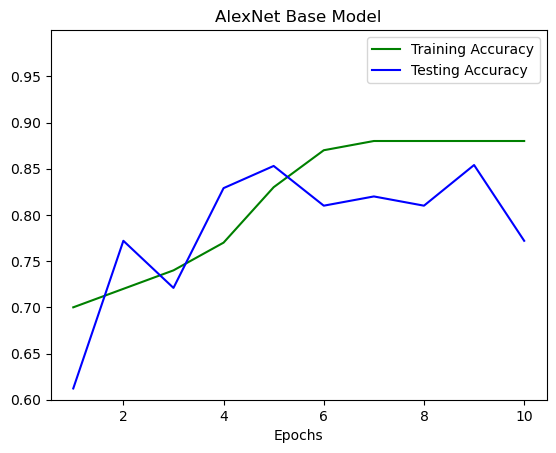

In [86]:
plt.plot(epochs, training_epoch, 'g', label='Training Accuracy')
plt.plot(epochs, testing_epoch, 'b', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.title('AlexNet Base Model')
plt.ylim(0.6, 1.0)
plt.legend()
plt.show()

In [94]:
j*64

5952

In [48]:
testing_accuracy=5104/5972
testing_accuracy

0.854655056932351

In [95]:
correct_ones.item()

4794

WE got a **85.4%** accuracy on the testing data

# Modify AlexNet Structure
Now let's implement the alexnet with the initial actual size and applying normalization

In [15]:
transformation1=torchvision.transforms.Compose([
#     transforms.Resize(64),
#     transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
dataset1 = torchvision.datasets.ImageFolder(root='cnn_dataset', transform=transformation1)

In [17]:
train_size1 = int(0.8 * len(dataset1))
testing_size1 = len(dataset1) - train_size1
train_dataset1, testing_dataset1 = random_split(dataset1, [train_size1, testing_size1])

In [18]:
train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=64, shuffle=True, num_workers=4)
testing_loader1=torch.utils.data.DataLoader(testing_dataset1,batch_size=64,shuffle=False,num_workers=4)

In [22]:
len(dataset1)

30000

In [8]:
for i,data in enumerate(train_loader):
    inputs,labels=data
    if( i==0):
        print(inputs.shape)
    

torch.Size([64, 3, 224, 224])


In [10]:
print(inputs.shape)

torch.Size([64, 3, 64, 64])


Changing the kernel from 11 to 7 and decreasing the number of layers since our original pixel size is 64.

In [11]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=2),#111,
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=7,stride=2,padding=2),#55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),#26,
            nn.Conv2d(128, 256, kernel_size=5, padding=2),#26,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#12,
            nn.Conv2d(256, 384, kernel_size=3, padding=1),#12,
            nn.ReLU(inplace=True),
#             nn.Conv2d(384, 384, kernel_size=3, padding=1),#12,
#             nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),#12,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#5
            nn.Flatten(),
            nn.Linear(6400, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096,3))
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x=self.features(x)
        x=self.softmax(x)
        return x

In [12]:
model1=AlexNet().to(device)

In [9]:
model1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=6400, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_feat

Changing the Optimizer from Stochastic gradient descent to adam optimizer

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01,momentum=0.8)
def train_one_epoch(epoch_index):
    training_correct_ones=0
    running_loss=0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        #inputs= inputs.to(torch.float64)
        outputs = model1(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        maxi,predictions=torch.max(outputs,1)
        training_correct_ones+=(predictions==labels.to(device)).sum().item()
        if i % 100 == 99:    
            print(f'current epoch:{epoch_index},running_loss is {running_loss}')
            running_loss = 0.0
    return training_correct_ones 

implementing earlystopping to improve the training time.If the testing error doesn't decrease after 3 epochs we break out of the loop.

In [13]:
epochs=10
training_epochs_modified=[]
testing_epochs_modified=[]
earlystopping=0
modified_t0=time.time()
for epoch in range(epochs):
    correct_ones=0
    model1.train(True)
    training_correct_ones=train_one_epoch(epoch)
    model1.train(False)
    #testing error is
    for j,test_data in enumerate(testing_loader):
        test_inputs,test_labels=test_data
        test_inputs,test_labels=test_inputs.to(device),test_labels.to(device)
        test_outputs=model1(test_inputs)
        maxi,predictions=torch.max(test_outputs,1)
        correct_ones+=(predictions==test_labels).sum()
        
    training_epochs_modified.append(training_correct_ones)
    
    if(epoch==0):
        testing_epochs_modified.append(correct_ones.item())
    elif (correct_ones<=max(testing_epochs_modified)):
        earlystopping+=1
        testing_epochs_modified.append(correct_ones.item())
    else:
        earlystopping=0
        testing_epochs_modified.append(correct_ones.item())
    if(earlystopping==3):
        testing_epochs_modified.append(correct_ones.item())
        break
    print(correct_ones)
modified_final_time=time.time()-modified_t0
print(modified_final_time)

current epoch:0,running_loss is 84.48272305727005
current epoch:0,running_loss is 77.56338143348694
current epoch:0,running_loss is 77.25617027282715
tensor(4794, device='mps:0')
current epoch:1,running_loss is 73.11358672380447
current epoch:1,running_loss is 73.70559614896774
current epoch:1,running_loss is 72.66755026578903
tensor(4994, device='mps:0')
current epoch:2,running_loss is 72.39359641075134
current epoch:2,running_loss is 71.17345541715622
current epoch:2,running_loss is 71.6479241847992
tensor(5093, device='mps:0')
current epoch:3,running_loss is 70.21776610612869
current epoch:3,running_loss is 70.95556175708771
current epoch:3,running_loss is 69.92477107048035
tensor(4940, device='mps:0')
current epoch:4,running_loss is 69.80430752038956
current epoch:4,running_loss is 71.32955777645111
current epoch:4,running_loss is 68.77063429355621
tensor(5168, device='mps:0')
current epoch:5,running_loss is 68.78195434808731
current epoch:5,running_loss is 70.57218909263611
curren

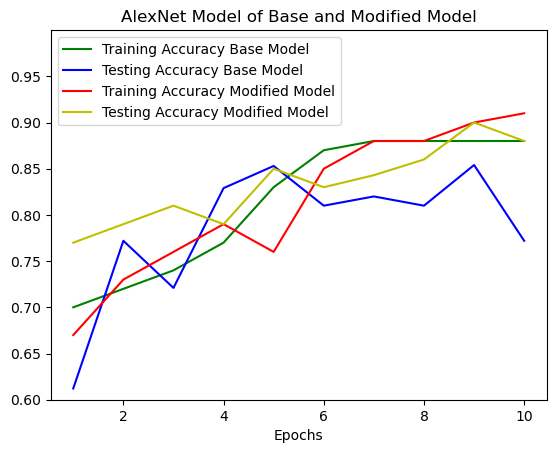

In [87]:

epochs = range(1, 11)
plt.plot(epochs, training_epoch, 'g', label='Training Accuracy Base Model')
plt.plot(epochs, testing_epoch, 'b', label='Testing Accuracy Base Model')
plt.plot(epochs, training_epochs_modified, 'r', label='Training Accuracy Modified Model')
plt.plot(epochs, testing_epochs_modified, 'y', label='Testing Accuracy Modified Model')
plt.xlabel('Epochs')
plt.title('AlexNet Model of Base and Modified Model')
plt.ylim(0.6, 1.0)
plt.legend()
plt.show()

In [12]:
testing_epochs_modified

[3077, 3970, 3746]

In [14]:
(5322/(j*64))*100

89.41532258064517

We got an accuracy close to 90% after modifying the alexnet where
We have replaced 11 kernel and 4 stride with 2 conv layers of ke 

In [30]:
time.time()

1681339043.121814

Part 1

# Part 4

In [4]:
image_np, ann_dict = svhnl.gen_dataset(image_path='../data/svhn/train', mat_path='../data/svhn/train/digitStruct.mat')

In [7]:
train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True)
test_set = torchvision.datasets.SVHN(root='./data', split='test', download=True)

100%|████████████████████████| 182040794/182040794 [00:31<00:00, 5740452.33it/s]


100%|██████████████████████████| 64275384/64275384 [00:08<00:00, 7370071.27it/s]


In [8]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
train_set.transform = train_transform
test_set.transform = test_transform

In [13]:
train_set.labels

array([1, 9, 2, ..., 1, 6, 9])

Text(0, 0.5, 'frequency')

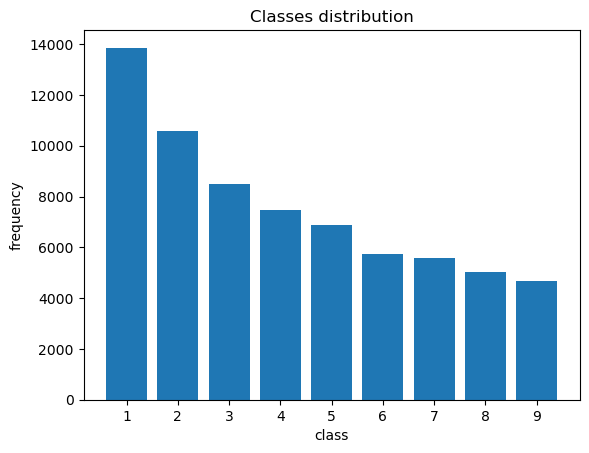

In [100]:
plt.bar(range(1,10),np.bincount(train_set.labels)[1:])
plt.xticks(np.arange(1,10))
plt.title('Classes distribution')
plt.xlabel('class')
plt.ylabel('frequency')

Text(0, 0.5, 'Frequency')

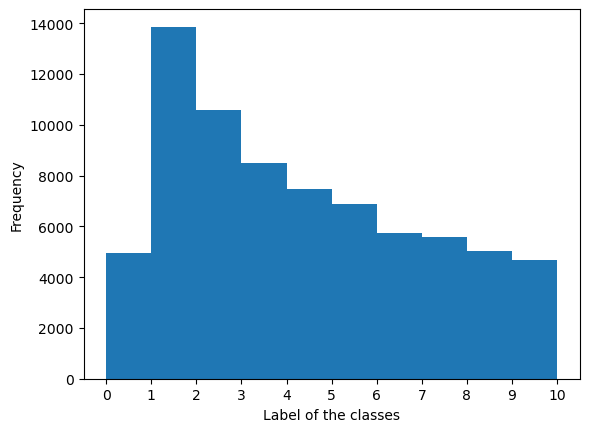

In [109]:
figure, axi = plt.subplots()
Labels = [label for i, label in train_set]
axi.hist(abels, bins=range(11))
axi.set_xticks(range(11))
axi.set_xlabel('Label of the classes')
axi.set_ylabel('Frequency')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


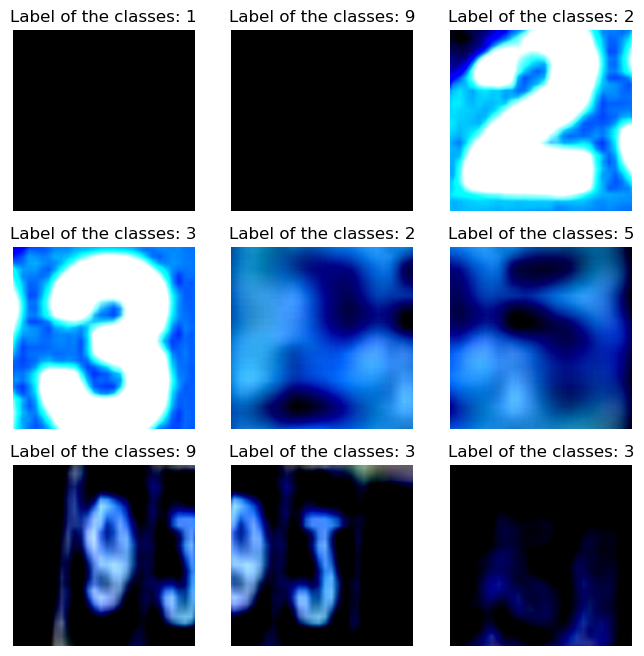

In [108]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
for j, axi in enumerate(axes.flat):
    img, label = train_set[j]
    axi.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axi.set_title(f"Label of the classes: {label}")
    axi.axis('off')
plt.show()   

In [61]:
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,num_workers=8)
testing_loader2 =torch.utils.data.DataLoader(test_set,batch_size=64, shuffle=False,num_workers=8)

The main adjustment we made from the cnn architecture of our improved version from part3 and adjusted to 10 classes to include these class labels:

{0,1,2,3,4,5,6,7,8,9} 

We also made each image to 224 pixels centercropped to match our alexnet configuration.

In [43]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=2),#111,
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=7,stride=2,padding=2),#55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=5, stride=2),#26,
            nn.Conv2d(128, 256, kernel_size=5, padding=2),#26,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#12,
            nn.Conv2d(256, 384, kernel_size=3, padding=1),#12,
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),#12,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),#5
            nn.Flatten(),
            nn.Linear(6400, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(4096,10))
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x=self.features(x)
        x=self.softmax(x)
        return x

In [44]:
model2=AlexNet().to(device)

In [45]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01,momentum=0.8)
def train_one_epoch(epoch_index):
    training_correct_ones=0
    running_loss=0.0
    for i, data in enumerate(train_loader2):
        inputs, labels = data
        optimizer.zero_grad()
        #inputs= inputs.to(torch.float64)
        outputs = model2(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        maxi,predictions=torch.max(outputs,1)
        training_correct_ones+=(predictions==labels.to(device)).sum().item()
        if i % 100 == 99:    
            print(f'current epoch:{epoch_index},running_loss is {running_loss}')
            running_loss = 0.0
    return training_correct_ones

In [46]:
epochs=10
training_epochs_modified_part4=[]
testing_epochs_modified_part4=[]
earlystopping=0
modified_t0=time.time()
for epoch in range(epochs):
    correct_ones=0
    model2.train(True)
    training_correct_ones=train_one_epoch(epoch)
    model2.train(False)
    #testing error is
    for j,test_data in enumerate(testing_loader2):
        test_inputs,test_labels=test_data
        test_inputs,test_labels=test_inputs.to(device),test_labels.to(device)
        test_outputs=model2(test_inputs)
        maxi,predictions=torch.max(test_outputs,1)
        correct_ones+=(predictions==test_labels).sum()
        
    training_epochs_modified_part4.append(training_correct_ones)
    if(epoch==0):
        testing_epochs_modified_part4.append(correct_ones.item())
    elif (correct_ones<=max(testing_epochs_modified_part4)):
        earlystopping+=1
        testing_epochs_modified_part4.append(correct_ones.item())
    else:
        earlystopping=0
        testing_epochs_modified_part4.append(correct_ones.item())
    if(earlystopping==3):
        testing_epochs_modified_part4.append(correct_ones.item())
        break
    print(correct_ones)
modified_final_time=time.time()-modified_t0
print(modified_final_time)

current epoch:0,running_loss is 230.20450162887573
current epoch:0,running_loss is 230.08199620246887
current epoch:0,running_loss is 229.93719601631165
current epoch:0,running_loss is 229.81899404525757
current epoch:0,running_loss is 229.4475064277649
current epoch:0,running_loss is 226.90939736366272
current epoch:0,running_loss is 226.02729034423828
current epoch:0,running_loss is 226.3004195690155
current epoch:0,running_loss is 225.59044003486633
current epoch:0,running_loss is 226.48562383651733
current epoch:0,running_loss is 225.23316836357117
tensor(5099, device='mps:0')
current epoch:1,running_loss is 225.7131154537201
current epoch:1,running_loss is 225.2902126312256
current epoch:1,running_loss is 225.10666060447693
current epoch:1,running_loss is 224.36470317840576
current epoch:1,running_loss is 222.97596216201782
current epoch:1,running_loss is 218.17756867408752
current epoch:1,running_loss is 215.46629667282104
current epoch:1,running_loss is 212.8877820968628
current

In [90]:
training_epochs_modified_part4_graph=[ele/50000 for ele in training_epochs_modified_part4]
testing_epochs_modified_part4_graph=[ele/20000 for ele in testing_epochs_modified_part4]

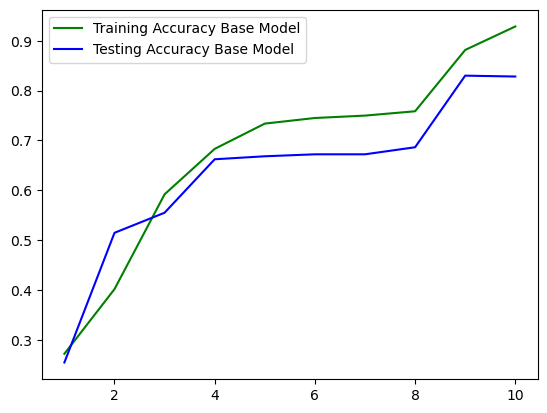

In [92]:
epochs = range(1, 11)
plt.plot(epochs, training_epochs_modified_part4_graph, 'g', label='Training Accuracy Base Model')
plt.plot(epochs, testing_epochs_modified_part4_graph, 'b', label='Testing Accuracy Base Model')
plt.title('Alexnet for SVHN without Augmentation')
plt.legend()
plt.show()

In [18]:
for i,data in enumerate(train_loader2):
    if(i==0):
        print(data[1])

tensor([6, 8, 2, 4, 6, 4, 3, 2, 2, 4, 4, 0, 1, 3, 3, 8, 2, 7, 7, 8, 2, 5, 2, 6,
        7, 0, 5, 4, 0, 6, 3, 6, 5, 9, 1, 3, 6, 1, 7, 5, 9, 2, 1, 1, 1, 0, 1, 1,
        1, 3, 5, 2, 1, 7, 0, 8, 7, 2, 3, 0, 2, 1, 5, 0])


In [49]:
len(train_loader2)*64

73280

# Data Augmentation

Seems the model is not ideal for this dataset let's make some changes in the cnn model.
Adding the data augmentation techniques to the original dataset to increase the dataset.

In [51]:
data_augmentation_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
)

In [52]:
augment_train_set = torchvision.datasets.SVHN(root='./data', split='train', download=True,transform=data_augmentation_transform)

Using downloaded and verified file: ./data/train_32x32.mat


Adding the original train set to the augmented train set

In [53]:
full_dataset = torch.utils.data.ConcatDataset([train_set, augment_train_set])

In [63]:
train_dataloader3=torch.utils.data.DataLoader(full_dataset, batch_size=32, shuffle=True,num_workers=8)


In [64]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01,momentum=0.8)
def train_one_epoch(epoch_index):
    training_correct_ones=0
    running_loss=0.0
    for i, data in enumerate(train_dataloader3):
        inputs, labels = data
        optimizer.zero_grad()
        #inputs= inputs.to(torch.float64)
        outputs = model2(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        maxi,predictions=torch.max(outputs,1)
        training_correct_ones+=(predictions==labels.to(device)).sum().item()
        if i % 100 == 99:    
            print(f'current epoch:{epoch_index},running_loss is {running_loss}')
            running_loss = 0.0
    return training_correct_ones

In [65]:
epochs=2
training_epochs_modified_part4_data_augmentation=[]
testing_epochs_modified_part4_data_augmentation=[]
earlystopping=0
modified_t0=time.time()
for epoch in range(epochs):
    correct_ones=0
    model2.train(True)
    training_correct_ones=train_one_epoch(epoch)
    model2.train(False)
    #testing error is
    for j,test_data in enumerate(testing_loader2):
        test_inputs,test_labels=test_data
        test_inputs,test_labels=test_inputs.to(device),test_labels.to(device)
        test_outputs=model2(test_inputs)
        maxi,predictions=torch.max(test_outputs,1)
        correct_ones+=(predictions==test_labels).sum()
        
    training_epochs_modified_part4_data_augmentation.append(training_correct_ones)
    if(epoch==0):
        testing_epochs_modified_part4_data_augmentation.append(correct_ones.item())
    elif (correct_ones<=max(testing_epochs_modified_part4_data_augmentation)):
        earlystopping+=1
        testing_epochs_modified_part4_data_augmentation.append(correct_ones.item())
    else:
        earlystopping=0
        testing_epochs_modified_part4_data_augmentation.append(correct_ones.item())
    if(earlystopping==3):
        testing_epochs_modified_part4_data_augmentation.append(correct_ones.item())
        break
    print(correct_ones)
modified_final_time_part4_data_augmentation=time.time()-modified_t0
print(modified_final_time_part4_data_augmentation)

current epoch:0,running_loss is 227.61501693725586
current epoch:0,running_loss is 226.99001693725586
current epoch:0,running_loss is 225.2729766368866
current epoch:0,running_loss is 226.70659732818604
current epoch:0,running_loss is 226.67751693725586
current epoch:0,running_loss is 226.2389748096466
current epoch:0,running_loss is 226.80251693725586
current epoch:0,running_loss is 225.92751240730286
current epoch:0,running_loss is 227.48931217193604
current epoch:0,running_loss is 226.52126669883728
current epoch:0,running_loss is 227.02126693725586
current epoch:0,running_loss is 227.45876693725586
current epoch:0,running_loss is 227.17751693725586
current epoch:0,running_loss is 225.99001693725586
current epoch:0,running_loss is 226.70876693725586
current epoch:0,running_loss is 226.64626693725586
current epoch:0,running_loss is 227.2087333202362
current epoch:0,running_loss is 226.39626693725586
current epoch:0,running_loss is 227.39694809913635
current epoch:0,running_loss is 22

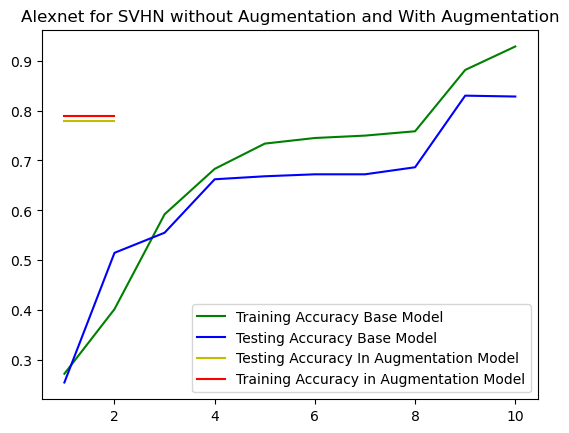

In [94]:
epochs = range(1, 11)
plt.plot(epochs, training_epochs_modified_part4_graph, 'g', label='Training Accuracy Base Model')
plt.plot(epochs, testing_epochs_modified_part4_graph, 'b', label='Testing Accuracy Base Model')
epochs2=range(1,3)
plt.plot(epochs2,testing_epoch,'y',label='Testing Accuracy In Augmentation Model')
plt.plot(epochs2,training_epoch,'r',label='Training Accuracy in Augmentation Model')
plt.title('Alexnet for SVHN without Augmentation and With Augmentation')
plt.legend()
plt.show()

We have used earlystopping and there was no increase in the testing accuracy in the augmentation model because of the size of the model and the size of the training dataset it was unwise for us to proceed forward with more epochs for Augmentation Model